🔍 Testing Network Connectivity:
✅ Google DNS (8.8.8.8): Connected
✅ Google Sheets (docs.google.com): Connected
✅ Google Main (google.com): Connected
🔄 Attempt 1/3 using requests...
✅ Data loaded successfully!
📊 Dataset shape: (224, 14)

🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 14 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   Timestamp                                                      224 non-null    object
 1   Name                                                           220 non-null    object
 2   Sex                                                            224 non-null    object
 3   Age                                                            224 non-null    object
 4   Mail ID                                                        156 non-null    object
 5   

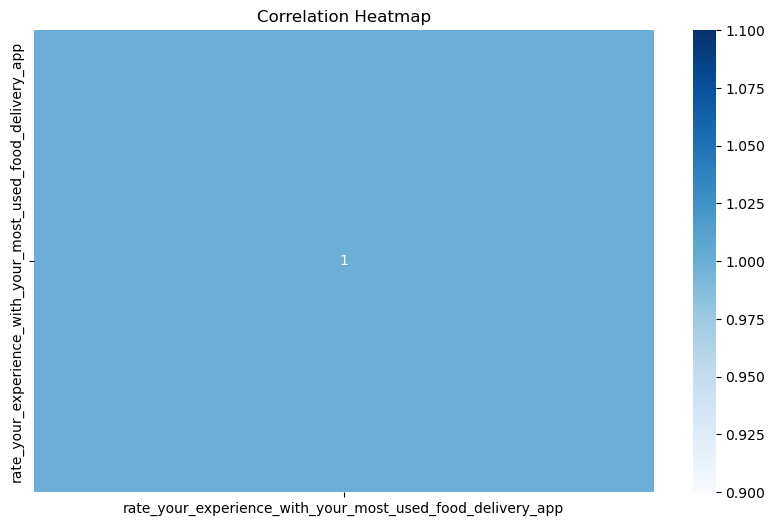

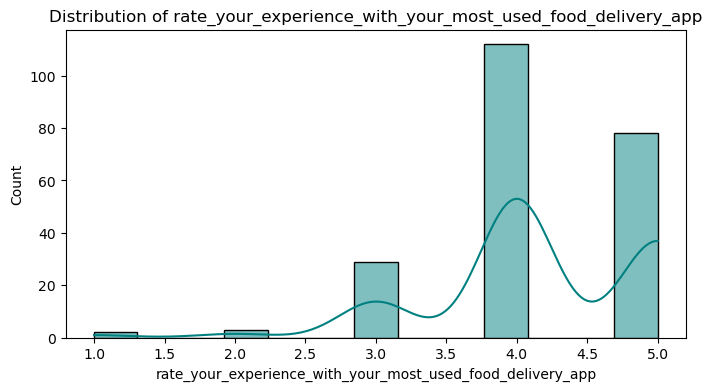

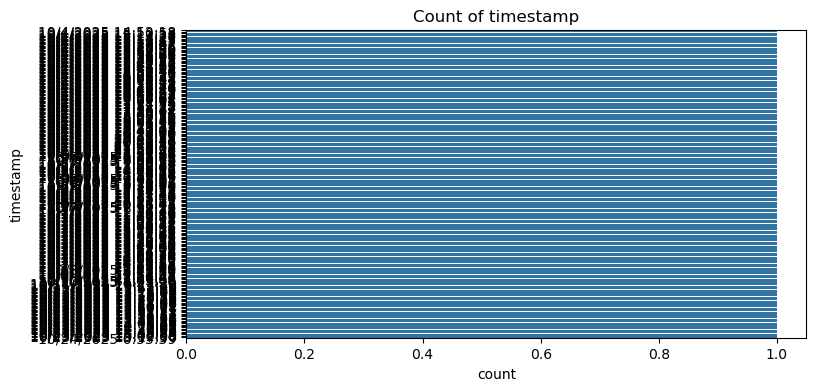

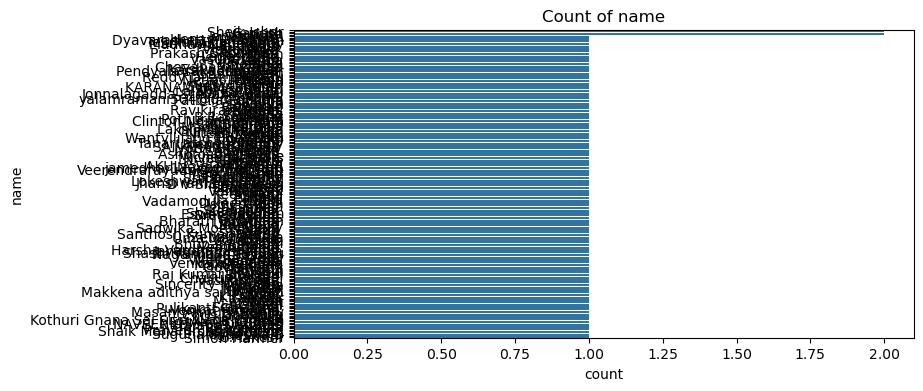

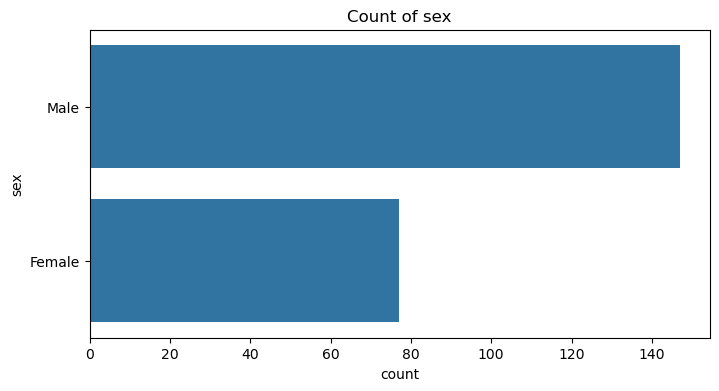

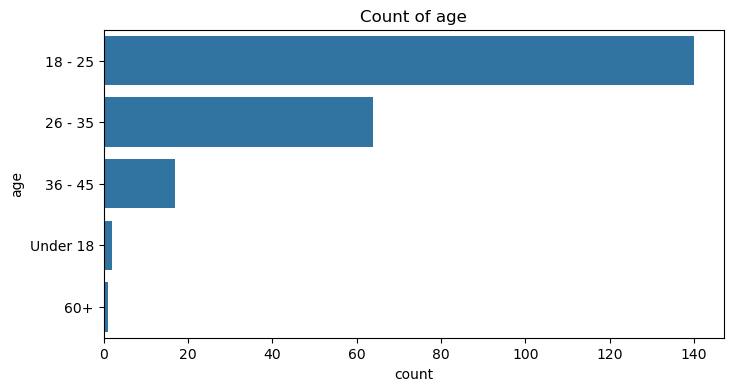

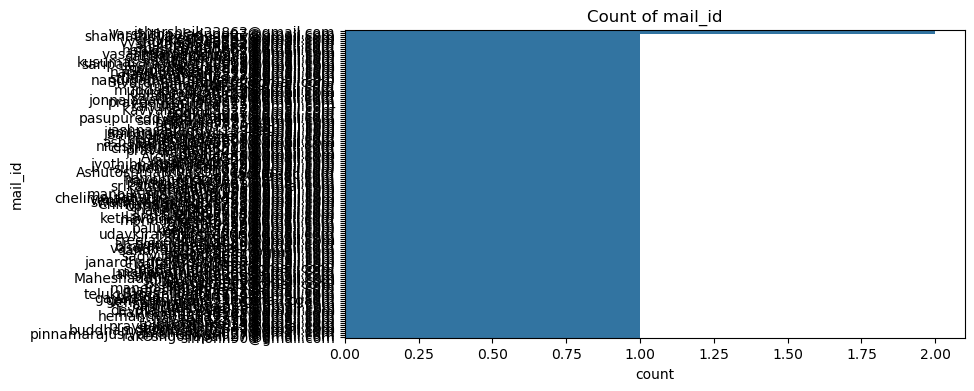

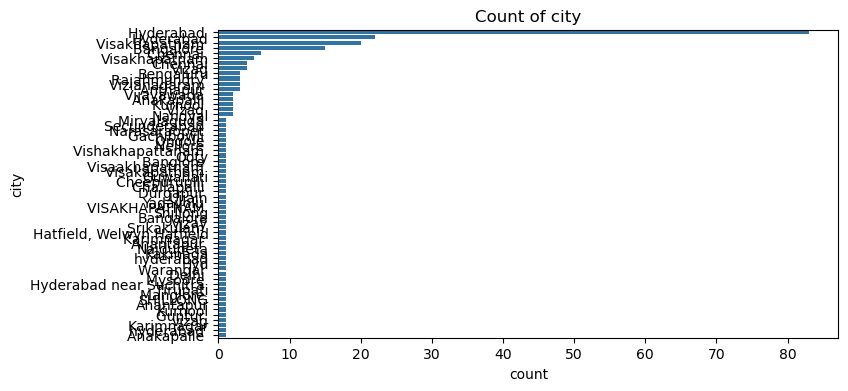

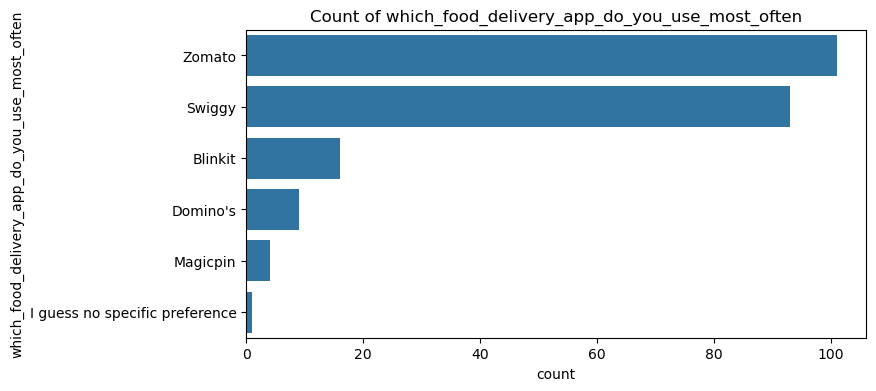

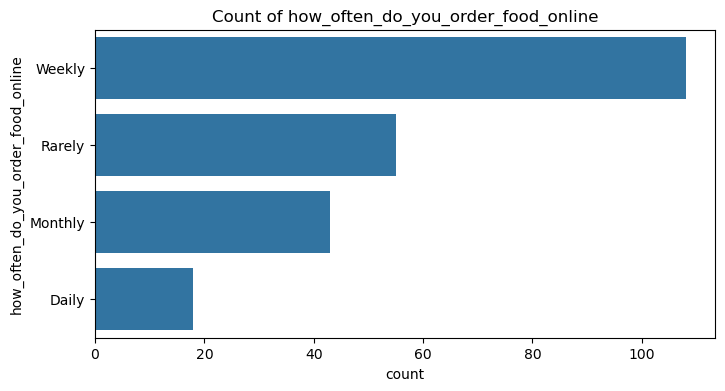

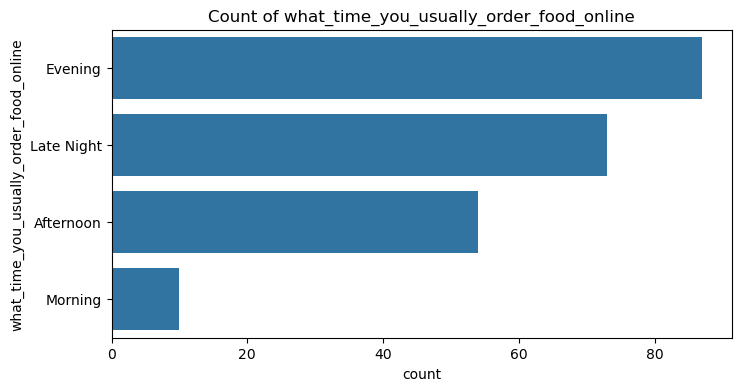

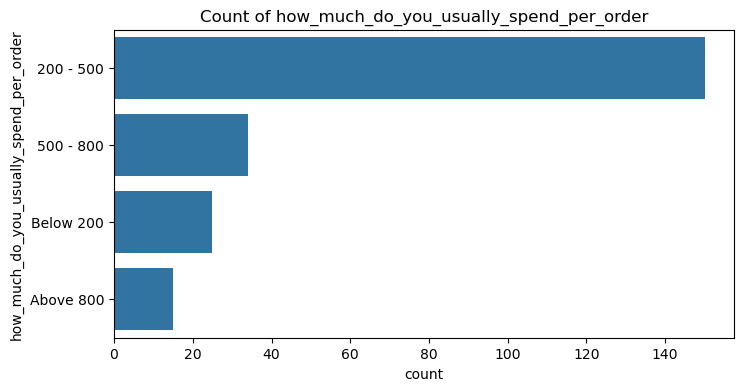

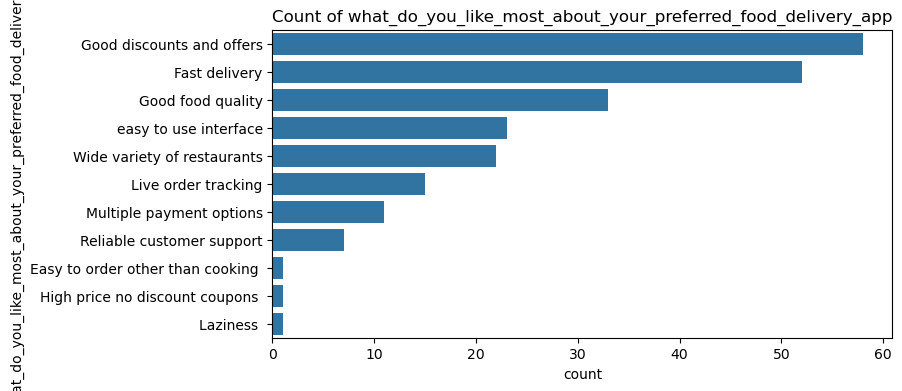

C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 140 (\x8c) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 155 (\x9b) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 153 (\x99) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


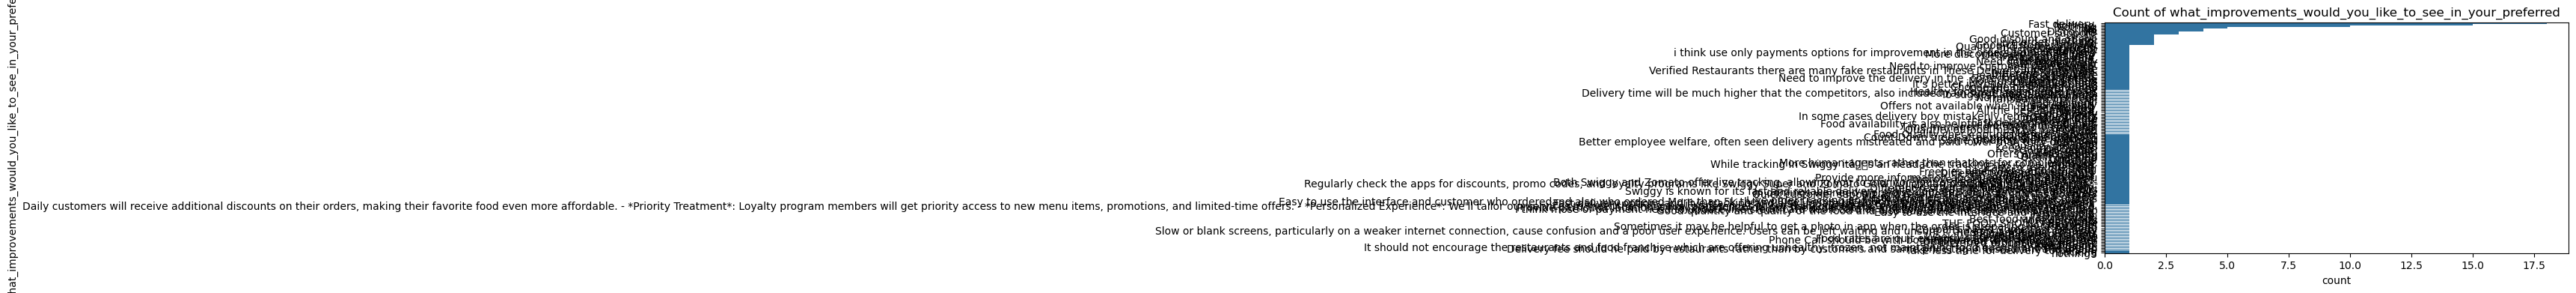

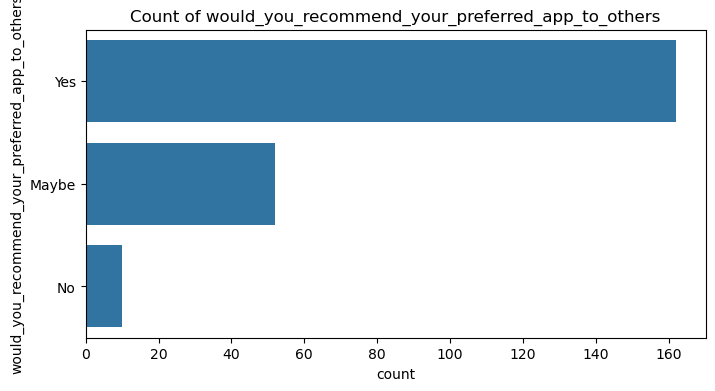

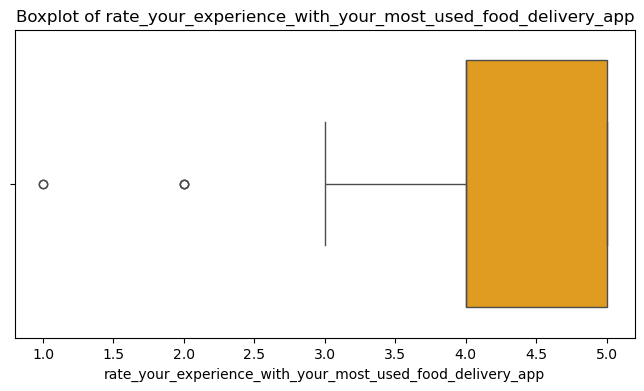


🔍 Schema Comparison for table 'google_sheet_data':
📊 DataFrame columns (14): ['timestamp', 'name', 'sex', 'age', 'mail_id', 'city', 'which_food_delivery_app_do_you_use_most_often', 'how_often_do_you_order_food_online', 'what_time_you_usually_order_food_online', 'how_much_do_you_usually_spend_per_order', 'rate_your_experience_with_your_most_used_food_delivery_app', 'what_do_you_like_most_about_your_preferred_food_delivery_app', 'what_improvements_would_you_like_to_see_in_your_preferred', 'would_you_recommend_your_preferred_app_to_others']
🗄️ Database columns (14): ['timestamp', 'name', 'sex', 'age', 'mail_id', 'city', 'which_food_delivery_app_do_you_use_most_often', 'how_often_do_you_order_food_online', 'what_time_you_usually_order_food_online', 'how_much_do_you_usually_spend_per_order', 'rate_your_experience_with_your_most_used_food_delivery_app', 'what_do_you_like_most_about_your_preferred_food_delivery_app', 'what_improvements_would_you_like_to_see_in_your_preferred', 'would_you_rec

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
import re
import requests
import socket
from io import StringIO
import time

class GoogleSheetAnalyzer:
    """
    A comprehensive class for analyzing, visualizing, and storing data directly from a Google Sheet.
    It also supports saving data into a PostgreSQL database, with automatic schema inference.

    Attributes
    ----------
    sheet_id : str
        The unique ID of the Google Sheet.
    data : pd.DataFrame
        DataFrame containing the sheet data.

    Methods
    -------
    # Enhanced Data Loading
    load_data(method, timeout, retries): Loads the Google Sheet with network error handling.
    load_from_file(file_path): Load data from local CSV file as fallback.
    test_network_connection(): Test network connectivity to Google Sheets.
    
    # Basic Analysis
    show_basic_info(): Displays dataset info, columns, missing values, and summary statistics.
    unique_value_summary(): Prints the count of unique values in each column.
    top_frequent_values(): Prints top 5 frequent categorical values for each column.
    
    # Column Renaming Methods
    rename_columns_with_dict(column_mapping): Rename specific columns using a dictionary mapping.
    standardize_column_names(): Standardize column names to snake_case format suitable for databases.
    clean_column_names(): Clean column names by removing spaces, special characters, and standardizing case.
    replace_column_spaces(replacement): Replace spaces in column names with specified character.
    rename_all_columns(new_column_names): Rename all columns using a list of new names.
    show_column_suggestions(): Show current column names and suggest standardized versions.
    
    # Visualizations
    plot_correlation_heatmap(): Displays a correlation heatmap for numeric columns.
    plot_distributions(): Displays histograms for all numeric columns.
    plot_categorical_counts(): Displays count plots for all categorical columns.
    plot_boxplots(): Displays boxplots for numeric columns to detect outliers.
    
    # Enhanced PostgreSQL Methods
    infer_sql_type(dtype): Infers SQL data type based on pandas dtype.
    generate_create_table_statement(table_name): Generates a SQL CREATE TABLE statement.
    drop_table_if_exists(conn_params, table_name): Drop table to avoid schema conflicts.
    save_to_postgres(conn_params, table_name, recreate_table): Creates/recreates table and inserts data.
    check_table_schema(conn_params, table_name): Compare DataFrame vs database columns.
    sync_table_schema(conn_params, table_name): Recreate table with current DataFrame schema.
    """

    def __init__(self, sheet_id: str):
        """Initializes the GoogleSheetAnalyzer with a Google Sheet ID."""
        self.sheet_id = sheet_id
        self.data = None

    # ================= ENHANCED DATA LOADING =================
    def load_data(self, method='pandas', timeout=30, retries=3):
        """
        Enhanced data loading with multiple methods and network error handling.
        
        Parameters
        ----------
        method : str, default 'pandas'
            Loading method: 'pandas', 'requests'
        timeout : int, default 30
            Timeout in seconds for network requests
        retries : int, default 3
            Number of retry attempts
        """
        csv_url = f"https://docs.google.com/spreadsheets/d/{self.sheet_id}/export?format=csv"
        
        # Set socket timeout
        original_timeout = socket.getdefaulttimeout()
        socket.setdefaulttimeout(timeout)
        
        try:
            if method == 'pandas':
                self.data = self._load_with_pandas(csv_url, retries)
            elif method == 'requests':
                self.data = self._load_with_requests(csv_url, timeout, retries)
            else:
                print("⚠️ Invalid method. Use 'pandas' or 'requests'")
                return
                
            if self.data is not None:
                print("✅ Data loaded successfully!")
                print(f"📊 Dataset shape: {self.data.shape}")
                return self.data
            else:
                self._show_manual_instructions()
                
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            self._show_troubleshooting_guide()
            
        finally:
            # Restore original timeout
            socket.setdefaulttimeout(original_timeout)

    def _load_with_pandas(self, csv_url, retries):
        """Load data using pandas with retry mechanism."""
        for attempt in range(retries):
            try:
                print(f"🔄 Attempt {attempt + 1}/{retries} using pandas...")
                data = pd.read_csv(csv_url)
                return data
            except Exception as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e}")
                if attempt < retries - 1:
                    time.sleep(2)  # Wait before retry
                else:
                    return None

    def _load_with_requests(self, csv_url, timeout, retries):
        """Load data using requests library with retry mechanism."""
        for attempt in range(retries):
            try:
                print(f"🔄 Attempt {attempt + 1}/{retries} using requests...")
                response = requests.get(csv_url, timeout=timeout)
                response.raise_for_status()
                
                # Convert to pandas DataFrame
                csv_content = StringIO(response.text)
                data = pd.read_csv(csv_content)
                return data
                
            except requests.exceptions.RequestException as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e}")
                if attempt < retries - 1:
                    time.sleep(2)  # Wait before retry
                else:
                    return None

    def load_from_file(self, file_path):
        """
        Load data from a local CSV file as fallback.
        
        Parameters
        ----------
        file_path : str
            Path to the local CSV file
        """
        try:
            self.data = pd.read_csv(file_path)
            print("✅ Data loaded successfully from local file!")
            print(f"📊 Dataset shape: {self.data.shape}")
            return self.data
        except Exception as e:
            print(f"❌ Error loading from file: {e}")

    def test_network_connection(self):
        """Test network connectivity to Google Sheets."""
        test_urls = [
            ("Google DNS", "8.8.8.8"),
            ("Google Sheets", "docs.google.com"),
            ("Google Main", "google.com")
        ]
        
        print("🔍 Testing Network Connectivity:")
        print("=" * 50)
        
        for name, host in test_urls:
            try:
                socket.create_connection((host, 80 if host != "8.8.8.8" else 53), timeout=10)
                print(f"✅ {name} ({host}): Connected")
            except socket.error as e:
                print(f"❌ {name} ({host}): Failed - {e}")

    def _show_manual_instructions(self):
        """Show manual download instructions."""
        manual_url = f"https://docs.google.com/spreadsheets/d/{self.sheet_id}/export?format=csv"
        
        print("\n" + "="*70)
        print("📥 MANUAL DOWNLOAD INSTRUCTIONS")
        print("="*70)
        print("Since automatic loading failed, please follow these steps:")
        print()
        print("1️⃣ Copy this URL:")
        print(f"   {manual_url}")
        print()
        print("2️⃣ Paste it in your web browser")
        print("3️⃣ The CSV file will download automatically")
        print("4️⃣ Save it to your project folder")
        print("5️⃣ Load it using:")
        print("   analyzer.load_from_file('your_downloaded_file.csv')")
        print()
        print("="*70)

    def _show_troubleshooting_guide(self):
        """Show comprehensive troubleshooting guide."""
        print("\n" + "="*70)
        print("🔧 NETWORK TROUBLESHOOTING GUIDE")
        print("="*70)
        print()
        print("🌐 CHECK YOUR CONNECTION:")
        print("   • Ensure you have internet access")
        print("   • Try opening google.com in your browser")
        print("   • Check if you're behind a corporate firewall")
        print()
        print("🛠️ PYTHON SOLUTIONS:")
        print("   • Try: analyzer.load_data(method='requests')")
        print("   • Increase timeout: analyzer.load_data(timeout=60)")
        print("   • Test network: analyzer.test_network_connection()")
        print()
        print("🏢 CORPORATE NETWORK:")
        print("   • Contact your IT department")
        print("   • Configure proxy settings if needed")
        print("   • Use VPN if allowed")
        print()
        print("📱 ALTERNATIVE METHODS:")
        print("   • Download CSV manually from Google Sheets")
        print("   • Use Google Colab (has better network access)")
        print("   • Try from a different network (mobile hotspot)")
        print()
        print("="*70)

    # ================= BASIC ANALYSIS =================
    def show_basic_info(self):
        """Displays dataset info, missing values, and summary statistics."""
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        print("\n🔹 Dataset Info:")
        print(self.data.info())
        print("\n🔹 Missing Values:")
        print(self.data.isnull().sum())
        print("\n🔹 Summary Statistics:")
        print(self.data.describe())
        print("\n🔹 Columns:")
        print(self.data.columns.tolist())

    def unique_value_summary(self):
        """Displays number of unique values in each column."""
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        print("\n🔹 Unique Value Counts:")
        for col in self.data.columns:
            print(f"{col}: {self.data[col].nunique()} unique values")

    def top_frequent_values(self):
        """Displays top 5 frequent categorical values for each column."""
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        print("\n🔹 Top 5 Frequent Values per Column:")
        for col in self.data.select_dtypes(include='object').columns:
            print(f"\n{col}:\n{self.data[col].value_counts().head()}")

    # ================= COLUMN RENAMING METHODS =================
    def rename_columns_with_dict(self, column_mapping: dict):
        """
        Rename specific columns using a dictionary mapping.
        
        Parameters
        ----------
        column_mapping : dict
            Dictionary where keys are old column names and values are new names.
            Example: {'Old Name': 'new_name', 'Another Col': 'another_col'}
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        
        self.data = self.data.rename(columns=column_mapping)
        print(f"✅ Columns renamed: {list(column_mapping.keys())} -> {list(column_mapping.values())}")
        return self.data

    def standardize_column_names(self):
        """
        Standardize column names to snake_case format suitable for databases.
        - Converts to lowercase
        - Replaces spaces and special characters with underscores
        - Removes consecutive underscores
        - Removes leading/trailing underscores
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        
        old_columns = self.data.columns.tolist()
        new_columns = []
        
        for col in self.data.columns:
            # Convert to lowercase
            clean_col = col.lower()
            # Replace spaces and special characters with underscores
            clean_col = re.sub(r'[^a-z0-9]+', '_', clean_col)
            # Remove consecutive underscores
            clean_col = re.sub(r'_+', '_', clean_col)
            # Remove leading/trailing underscores
            clean_col = clean_col.strip('_')
            # Ensure column name doesn't start with a number
            if clean_col and clean_col[0].isdigit():
                clean_col = 'col_' + clean_col
            new_columns.append(clean_col)
        
        self.data.columns = new_columns
        
        print("✅ Column names standardized to snake_case:")
        for old, new in zip(old_columns, new_columns):
            if old != new:
                print(f"  '{old}' -> '{new}'")
        
        return self.data

    def clean_column_names(self, remove_spaces=True, remove_special_chars=True, to_lowercase=True):
        """
        Clean column names by removing spaces, special characters, and standardizing case.
        
        Parameters
        ----------
        remove_spaces : bool, default True
            Remove spaces from column names
        remove_special_chars : bool, default True  
            Remove special characters from column names
        to_lowercase : bool, default True
            Convert column names to lowercase
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        
        old_columns = self.data.columns.tolist()
        
        # Apply cleaning operations
        if remove_spaces:
            self.data.columns = self.data.columns.str.replace(' ', '_')
        
        if remove_special_chars:
            self.data.columns = self.data.columns.str.replace(r'[#@&%$!]', '', regex=True)
        
        if to_lowercase:
            self.data.columns = self.data.columns.str.lower()
        
        print("✅ Column names cleaned:")
        for old, new in zip(old_columns, self.data.columns.tolist()):
            if old != new:
                print(f"  '{old}' -> '{new}'")
        
        return self.data

    def replace_column_spaces(self, replacement='_'):
        """
        Replace spaces in column names with specified character.
        
        Parameters
        ----------
        replacement : str, default '_'
            Character to replace spaces with
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        
        old_columns = self.data.columns.tolist()
        self.data.columns = self.data.columns.str.replace(' ', replacement)
        
        changed_columns = [(old, new) for old, new in zip(old_columns, self.data.columns.tolist()) if old != new]
        if changed_columns:
            print(f"✅ Spaces replaced with '{replacement}':")
            for old, new in changed_columns:
                print(f"  '{old}' -> '{new}'")
        else:
            print("ℹ️ No spaces found in column names")
        
        return self.data

    def rename_all_columns(self, new_column_names: list):
        """
        Rename all columns using a list of new names.
        
        Parameters
        ----------
        new_column_names : list
            List of new column names. Must match the number of columns.
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        
        if len(new_column_names) != len(self.data.columns):
            print(f"❌ Error: Number of new names ({len(new_column_names)}) doesn't match number of columns ({len(self.data.columns)})")
            return
        
        old_columns = self.data.columns.tolist()
        self.data.columns = new_column_names
        
        print("✅ All columns renamed:")
        for old, new in zip(old_columns, new_column_names):
            print(f"  '{old}' -> '{new}'")
        
        return self.data

    def show_column_suggestions(self):
        """
        Show current column names and suggest standardized versions.
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        
        print("\n🔹 Current vs Suggested Column Names:")
        print("-" * 60)
        
        for col in self.data.columns:
            # Create suggested name
            suggested = col.lower()
            suggested = re.sub(r'[^a-z0-9]+', '_', suggested)
            suggested = re.sub(r'_+', '_', suggested)
            suggested = suggested.strip('_')
            
            if suggested and suggested[0].isdigit():
                suggested = 'col_' + suggested
                
            if col != suggested:
                print(f"Current: '{col}' -> Suggested: '{suggested}'")
            else:
                print(f"'{col}' (already standardized)")

    # ================= VISUALIZATIONS =================
    def plot_correlation_heatmap(self):
        """Plots correlation heatmap for numeric columns."""
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        plt.figure(figsize=(10, 6))
        sns.heatmap(self.data.corr(numeric_only=True), annot=True, cmap="Blues")
        plt.title("Correlation Heatmap")
        plt.show()

    def plot_distributions(self):
        """Plots histograms for all numeric columns."""
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        num_cols = self.data.select_dtypes(include='number').columns
        for col in num_cols:
            plt.figure(figsize=(8, 4))
            sns.histplot(self.data[col], kde=True, color="teal")
            plt.title(f"Distribution of {col}")
            plt.show()

    def plot_categorical_counts(self):
        """Plots count plots for categorical columns."""
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        cat_cols = self.data.select_dtypes(include='object').columns
        for col in cat_cols:
            plt.figure(figsize=(8, 4))
            sns.countplot(y=self.data[col], order=self.data[col].value_counts().index)
            plt.title(f"Count of {col}")
            plt.show()

    def plot_boxplots(self):
        """Plots boxplots for numeric columns to detect outliers."""
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        num_cols = self.data.select_dtypes(include='number').columns
        for col in num_cols:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=self.data[col], color="orange")
            plt.title(f"Boxplot of {col}")
            plt.show()

    # ================= SQL TYPE INFERENCE =================
    @staticmethod
    def infer_sql_type(dtype):
        """
        Infers SQL data type from pandas dtype.
        """
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"

    # ================= SQL TABLE GENERATION =================
    def generate_create_table_statement(self, table_name="google_sheet_data"):
        """
        Generates a SQL CREATE TABLE statement based on DataFrame dtypes.
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        columns = self.data.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            {sql_columns}
        );
        """
        return create_stmt

    # ================= ENHANCED POSTGRESQL METHODS =================
    def drop_table_if_exists(self, conn_params, table_name):
        """
        Drop the table if it exists to avoid column mismatch errors.
        
        Parameters
        ----------
        conn_params : dict
            PostgreSQL connection parameters
        table_name : str
            Name of the table to drop
        """
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            drop_stmt = f"DROP TABLE IF EXISTS {table_name};"
            cur.execute(drop_stmt)
            conn.commit()
            
            cur.close()
            conn.close()
            print(f"✅ Table '{table_name}' dropped successfully")
            
        except Exception as e:
            print(f"❌ Error dropping table: {e}")

    def save_to_postgres(self, conn_params, table_name="google_sheet_data", recreate_table=False):
        """
        Creates the table (if not exists) and inserts DataFrame rows into PostgreSQL.
        
        Parameters
        ----------
        conn_params : dict
            PostgreSQL connection parameters
        table_name : str, default "google_sheet_data"
            Name of the table to create/insert into
        recreate_table : bool, default False
            Whether to drop and recreate the table if it exists
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return

        # Drop table if recreate_table is True
        if recreate_table:
            self.drop_table_if_exists(conn_params, table_name)

        create_stmt = self.generate_create_table_statement(table_name)

        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            # Create table
            cur.execute(create_stmt)
            conn.commit()
            print(f"✅ Table '{table_name}' created/verified successfully")

            # Prepare insert statement with current DataFrame columns
            columns = list(self.data.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
            """
            
            # Insert data row by row
            inserted_rows = 0
            for _, row in self.data.iterrows():
                try:
                    cur.execute(insert_stmt, tuple(row))
                    inserted_rows += 1
                except Exception as row_error:
                    print(f"⚠️ Error inserting row {inserted_rows + 1}: {row_error}")
                    continue
            
            conn.commit()
            cur.close()
            conn.close()
            
            print(f"✅ Data inserted successfully into PostgreSQL table: {table_name}")
            print(f"📊 Rows inserted: {inserted_rows} out of {len(self.data)}")

        except Exception as e:
            print(f"❌ Error during PostgreSQL operation: {e}")
            print("\n🔧 Troubleshooting Tips:")
            print("1. If you renamed columns after creating the table, use recreate_table=True")
            print("2. Check if the table already exists with different column names")
            print("3. Verify your PostgreSQL connection parameters")
            print("\n💡 Example: analyzer.save_to_postgres(conn_params, 'my_table', recreate_table=True)")

    def check_table_schema(self, conn_params, table_name):
        """
        Check the existing table schema and compare with current DataFrame columns.
        
        Parameters
        ----------
        conn_params : dict
            PostgreSQL connection parameters
        table_name : str
            Name of the table to check
        """
        if self.data is None:
            print("⚠️ Load data first using load_data() or load_from_file()")
            return
        
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            # Check if table exists
            cur.execute("""
            SELECT EXISTS (
                SELECT FROM information_schema.tables 
                WHERE table_name = %s
            );
            """, (table_name,))
            
            table_exists = cur.fetchone()[0]
            
            if not table_exists:
                print(f"ℹ️ Table '{table_name}' does not exist")
                cur.close()
                conn.close()
                return
            
            # Get existing table columns
            cur.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_name = %s
            ORDER BY ordinal_position;
            """, (table_name,))
            
            db_columns = cur.fetchall()
            cur.close()
            conn.close()
            
            # Compare with DataFrame columns
            df_columns = list(self.data.columns)
            db_column_names = [col[0] for col in db_columns]
            
            print(f"\n🔍 Schema Comparison for table '{table_name}':")
            print("=" * 60)
            print(f"📊 DataFrame columns ({len(df_columns)}): {df_columns}")
            print(f"🗄️ Database columns ({len(db_column_names)}): {db_column_names}")
            
            # Check for mismatches
            missing_in_db = set(df_columns) - set(db_column_names)
            extra_in_db = set(db_column_names) - set(df_columns)
            
            if missing_in_db:
                print(f"\n⚠️ Columns in DataFrame but NOT in database: {list(missing_in_db)}")
            
            if extra_in_db:
                print(f"\n⚠️ Columns in database but NOT in DataFrame: {list(extra_in_db)}")
            
            if not missing_in_db and not extra_in_db:
                print("\n✅ Column names match perfectly!")
            else:
                print(f"\n💡 Recommendation: Use recreate_table=True to fix schema mismatch")
                
            # Show database column details
            print(f"\n🗄️ Database Schema Details:")
            for col_name, col_type in db_columns:
                print(f"  {col_name}: {col_type}")
            
        except Exception as e:
            print(f"❌ Error checking table schema: {e}")

    def sync_table_schema(self, conn_params, table_name):
        """
        Synchronize the table schema with current DataFrame columns by recreating the table.
        
        Parameters
        ----------
        conn_params : dict
            PostgreSQL connection parameters
        table_name : str
            Name of the table to synchronize
        """
        print(f"🔄 Synchronizing table '{table_name}' schema with DataFrame columns...")
        self.save_to_postgres(conn_params, table_name, recreate_table=True)


# ================= EXAMPLE USAGE =================
if __name__ == "__main__":
    sheet_id = "1ll7hlJsePW6C-zIrUDeSXmiyJdHtJw5YJTsLzRzO2bU"
    analyzer = GoogleSheetAnalyzer(sheet_id)

    # Enhanced data loading with network error handling
    # Option 1: Test network first
    analyzer.test_network_connection()
    
    # Option 2: Try different loading methods
    analyzer.load_data(method='requests', timeout=60, retries=3)
    
    # Option 3: Fallback to local file if network fails
    # analyzer.load_from_file('your_file.csv')

    # Basic analysis
    if analyzer.data is not None:
        analyzer.show_basic_info()
        analyzer.unique_value_summary()
        analyzer.top_frequent_values()

        # Column renaming workflow
        analyzer.show_column_suggestions()
        analyzer.standardize_column_names()
        
        # Alternative column renaming methods:
        # analyzer.rename_columns_with_dict({'old_name': 'new_name'})
        # analyzer.clean_column_names()
        # analyzer.replace_column_spaces('_')

        # Visualizations
        analyzer.plot_correlation_heatmap()
        analyzer.plot_distributions()
        analyzer.plot_categorical_counts()
        analyzer.plot_boxplots()

        # Enhanced PostgreSQL workflow
        conn_params = {
            "dbname": "postgres",
            "user": "postgres",
            "password": "postgres",
            "host": "localhost",
            "port": "5432"
        }

        # Check schema first
        analyzer.check_table_schema(conn_params, "google_sheet_data")
        
        # Save with schema recreation to avoid conflicts
        analyzer.save_to_postgres(conn_params, table_name="google_sheet_data", recreate_table=True)


In [2]:
import pandas as pd

# Your Google Sheet ID
sheet_id = "1ll7hlJsePW6C-zIrUDeSXmiyJdHtJw5YJTsLzRzO2bU"

# Use CSV export format
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

# Read the sheet
data = pd.read_csv(csv_url)

# Display the table
data.tail(5)

,Timestamp,Name,Sex,Age,Mail ID,City,Which food delivery app do you use most often,How often do you order food online?,What time you usually order food online,How much do you usually spend per order,Rate your experience with your most-used food delivery app,What do you like most about your preferred food delivery app?,What improvements would you like to see in your preferred,Would you Recommend your preferred app to others?
219,10/23/2025 14:48:34,Suguna Syamala G,Female,18 - 25,syamala.gantla@gmail.com,Anakapalli,Zomato,Rarely,Afternoon,Below 200,4,Wide variety of restaurants,Nothing,Maybe
220,10/23/2025 14:48:53,Maheswari,Female,18 - 25,pinnamarajusivamaheswari027@gmail.com,Anakapalli,Zomato,Monthly,Late Night,200 - 500,4,Good food quality,Fast delivery,Yes
221,10/23/2025 15:02:09,Sheik Ishar,Male,18 - 25,isharsheik33863@gmail.com,Hyderabad,Swiggy,Weekly,Afternoon,200 - 500,3,Good discounts and offers,Tracking,Yes
222,10/23/2025 19:17:56,G.Rakesh,Male,18 - 25,rakeshgollapalli27@gmail.com,Hyderabad,Zomato,Weekly,Evening,200 - 500,4,Multiple payment options,nothing5,Yes
223,10/24/2025 6:55:59,Simon Harmer,Male,18 - 25,simonh90@gmail.com,Hyderabad,I guess no specific preference,Rarely,Evening,200 - 500,3,Good food quality,-,Maybe
